# CTCF
[autosomal dominant intellectual developmental disorder-21 (MRD21)](https://omim.org/entry/615502) is caused by heterozygous mutation in the CTCF gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


# CTCF
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CTCF.

In [2]:
gene_symbol = 'CTCF'
mane_tx_id = 'NM_006565.4'
mane_protein_id = 'NP_006556.1' # transcriptional repressor CTCF isoform 1"

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
len(phenopackets)


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 46/46 [00:03<00:00, 13.25individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Intellectual disability,HP:0001249,46
Global developmental delay,HP:0001263,46
Feeding difficulties,HP:0011968,31
Delayed speech and language development,HP:0000750,31
Failure to thrive,HP:0001508,22
Delayed ability to walk,HP:0031936,22
Hypotonia,HP:0001252,19
Microcephaly,HP:0000252,18
Recurrent infections,HP:0002719,18
Thin upper lip vermilion,HP:0000219,13


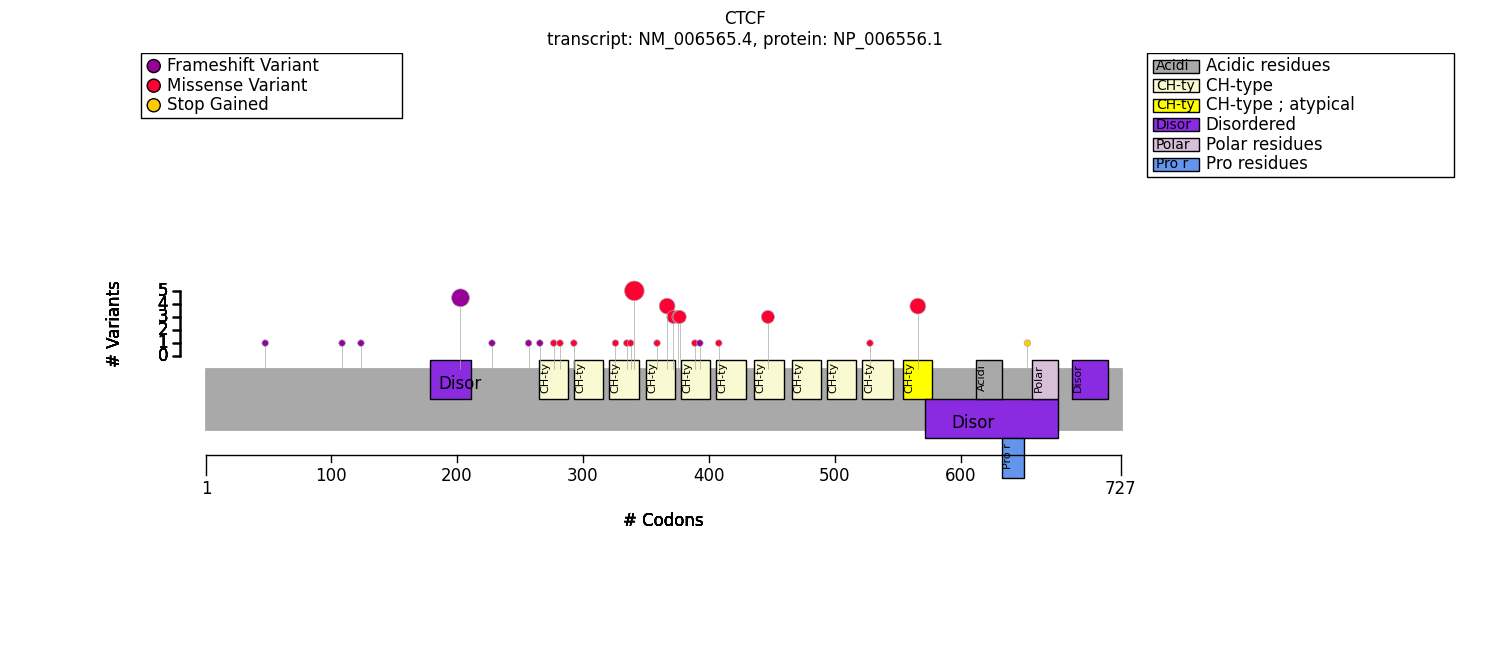

In [13]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

protein_meta = ProteinMetadata.from_uniprot_json(protein_id=mane_protein_id, label="CTCF",
                                                 uniprot_json="P49711.json",
                                                 protein_length=727)

ctcf_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
ctcf_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [11]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


missense_predicate = monoallelic_predicate(a_predicate=missense, 
                                     b_predicate=~missense, 
                                     a_label="missense", 
                                     b_label="other")
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,96
HMF03,Skipping term because of a child term with the same individual counts,6
HMF08,Skipping general term,57
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,156


In [12]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Feeding difficulties [HP:0011968]                     21/26     81%  10/17   
Recurrent infections [HP:0002719]                     13/25     52%   5/16   
Delayed speech and language development [HP:000...    20/24     83%  11/17   
Microcephaly [HP:0000252]                              9/25     36%   9/16   
Hypotonia [HP:0001252]                                13/22     59%   6/14   
Failure to thrive [HP:0001508]                        14/26     54%   8/17   
Intellectual disability [HP:0001249]                  29/29    100%  17/17   
Neurodevelopmental abnormality [HP:0012759]           29/29    100%  17/17   
Global developmental delay [HP:0001263]               29/29    100%  17/17   
Neurodevelopmental delay [HP:0012758]                 29/29    100%  17/17   
Abnormal eyelid morphology [HP:0000492]               13/13    100%    7/7   
Abnormal ocular adnexa morphology [HP:0030669]        15/15    100%    8/8   
Abnormal lip morphology [HP:0000159]                  13/13    100%    8/8   
Abnormal oral cavity morphology [HP:0000163]          14/14    100%    9/9   
Abdominal symptom [HP:0011458]                        22/22    100%  12/12   
Decreased body weight [HP:0004325]                    14/14    100%    8/8   
Abnormal axial skeleton morphology [HP:0009121]       12/12    100%  11/11   
Aplasia/Hypoplasia involving the central nervou...      9/9    100%  10/10   
Morphological central nervous system abnormalit...    13/13    100%  12/12   
Abnormal cerebral morphology [HP:0002060]             10/10    100%  10/10   
Abnormal brain morphology [HP:0012443]                11/11    100%  11/11   
Abnormal muscle tone [HP:0003808]                     17/17    100%    6/6   
Delayed ability to walk [HP:0031936]                  13/24     54%   9/16   
Delayed gross motor development [HP:0002194]          13/13    100%    9/9   
Language impairment [HP:0002463]                      20/20    100%  11/11   
Abnormal communication [HP:0034434]                   20/20    100%  11/11   
Abnormality of speech or vocalization [HP:0002167]    20/20    100%  11/11   

Allele group                                                                   \
                                                   Percent Corrected p values   
Feeding difficulties [HP:0011968]                      59%                1.0   
Recurrent infections [HP:0002719]                      31%                1.0   
Delayed speech and language development [HP:000...     65%                1.0   
Microcephaly [HP:0000252]                              56%                1.0   
Hypotonia [HP:0001252]                                 43%                1.0   
Failure to thrive [HP:0001508]                         47%                1.0   
Intellectual disability [HP:0001249]                  100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Abnormal eyelid morphology [HP:0000492]               100%                1.0   
Abnormal ocular adnexa morphology [HP:0030669]        100%                1.0   
Abnormal lip morphology [HP:0000159]                  100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Abdominal symptom [HP:0011458]                        100%                1.0   
Decreased body weight [HP:0004325]                    100%                1.0   
Abnormal axial skeleton morphology [HP:0009121]       100%                1.0   
Aplasia/Hypoplasia involving the central nervou...    100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Abnormal cerebral morphology [HP:000

In [14]:
from gpsea.analysis.predicate.genotype import sex_predicate
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Hypotonia [HP:0001252]                              12/17     71%   7/19   
Delayed speech and language development [HP:000...  10/17     59%  21/24   
Delayed ability to walk [HP:0031936]                12/17     71%  10/23   
Failure to thrive [HP:0001508]                      12/18     67%  10/25   
Feeding difficulties [HP:0011968]                   15/18     83%  16/25   
Recurrent infections [HP:0002719]                    9/17     53%   9/24   
Microcephaly [HP:0000252]                            9/18     50%   9/23   
Intellectual disability [HP:0001249]                18/18    100%  28/28   
Neurodevelopmental abnormality [HP:0012759]         18/18    100%  28/28   
Global developmental delay [HP:0001263]             18/18    100%  28/28   
Neurodevelopmental delay [HP:0012758]               18/18    100%  28/28   
Abnormal eyelid morphology [HP:0000492]             10/10    100%  10/10   
Abnormal ocular adnexa morphology [HP:0030669]      11/11    100%  12/12   
Abnormal lip morphology [HP:0000159]                  8/8    100%  13/13   
Abnormal oral cavity morphology [HP:0000163]          8/8    100%  15/15   
Abdominal symptom [HP:0011458]                      16/16    100%  18/18   
Decreased body weight [HP:0004325]                  12/12    100%  10/10   
Abnormal axial skeleton morphology [HP:0009121]     11/11    100%  12/12   
Aplasia/Hypoplasia involving the central nervou...    9/9    100%  10/10   
Morphological central nervous system abnormalit...  10/10    100%  15/15   
Abnormal cerebral morphology [HP:0002060]             9/9    100%  11/11   
Abnormal brain morphology [HP:0012443]              10/10    100%  12/12   
Abnormal muscle tone [HP:0003808]                   13/13    100%  10/10   
Delayed gross motor development [HP:0002194]        12/12    100%  10/10   
Language impairment [HP:0002463]                    10/10    100%  21/21   
Abnormal communication [HP:0034434]                 10/10    100%  21/21   
Abnormality of speech or vocalization [HP:0002167]  10/10    100%  21/21   

Sex                                                                            \
                                                   Percent Corrected p values   
Hypotonia [HP:0001252]                                 37%           0.838782   
Delayed speech and language development [HP:000...     88%           0.838782   
Delayed ability to walk [HP:0031936]                   43%           0.838782   
Failure to thrive [HP:0001508]                         40%           0.838782   
Feeding difficulties [HP:0011968]                      64%           1.000000   
Recurrent infections [HP:0002719]                      38%           1.000000   
Microcephaly [HP:0000252]                              39%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Abnormal eyelid morphology [HP:0000492]               100%           1.000000   
Abnormal ocular adnexa morphology [HP:0030669]        100%           1.000000   
Abnormal lip morphology [HP:0000159]                  100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   
Abdominal symptom [HP:0011458]                        100%           1.000000   
Decreased body weight [HP:0004325]                    100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Aplasia/Hypoplasia involving the central nervou...    100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Abnormal cere